<h1 style = "text-align:center"> <u> Recipe Recommendation System </u></h1>
<h2 style = "text-align:center"> Artificial Intelligence Project </h2>

## Contents

<ul>
    <li><a href = "#EDA"> Exploratory Data Analysis and Data Preprocessing </a></li>
        <ul>
            <li><a href = "#Recipes">Recipes Data</a></li>
            <li><a href = "#Reviews">Reviews Data</a></li>
            <li><a href = "#Process Data for Knowledge Based Filtering">Process Data for Knowledge Based Filtering</a></li>
            <li><a href = "#Process Data for Collaborative Filtering">Process Data for Collaborative Filtering</a></li>
            <li><a href = "#Process Data for Content Based Filtering">Process Data for Content Based Filtering</a></li>
        </ul>
    <li> <a href = "#Content Based Filtering">Content Based Filtering</a></li>
    <li> <a href = "#Knowledge Based Filtering (with Content-Based Integrated)">Knowledge Based Filtering (with Content-Based Integrated)</a> </li>
    <li> <a href="#Collaborative Filtering">Collaborative Filtering</a></li>
        <ul>
            <li><a href = "#Finding the Best Model">Finding the Best Model</a></li>
            <li><a href = "#Model Based Collaborative Filtering — SVD (with knowledge-based filtering and content-based filtering integrated)">Model Based Collaborative Filtering — SVD (with knowledge-based filtering and content-based filtering integrated)</a></li>
          </ul>  
    <li> <a href="#Switching Hybrid Model">Switching Hybrid Model</a></li>
</ul>

In [1]:
#Importing Libraries
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import ast
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer
from surprise import Dataset
from surprise import Reader
import matplotlib.pyplot as plt
from surprise import SVD, SVDpp, SlopeOne, NMF, NormalPredictor, KNNBaseline, KNNBasic, KNNWithMeans, KNNWithZScore, BaselineOnly, CoClustering, Reader, Dataset, accuracy
from surprise.model_selection import cross_validate, GridSearchCV, train_test_split

# <a name = 'EDA' style="color:#000000;"> Exploratory Data Analysis and Data Preprocessing </a>

In [2]:
#Loading the data
recipes_df = pd.read_csv("RAW_recipes.csv")
reviews_df = pd.read_csv("RAW_interactions.csv")

## <a name = Recipes style="color:#000000;"> Recipes Data </a>

In [3]:
recipes_df.shape

(231637, 12)

In [4]:
recipes_df.head(3)

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...","[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13


In [5]:
#Checking unique values
print('The recipes dataset has', recipes_df['id'].nunique(), 'unique recipes.')

The recipes dataset has 231637 unique recipes.


The `nutrition` column shows the calories and the percentage daily value (PDV) for total fat, sugar, sodium, protein, saturated fat and carbohydrates respectively. We will split this information into individual columns. 

In [6]:
#Renaming ID -> Recipe_ID
recipes_df = recipes_df.rename(columns = {'id': 'recipe_id'})

#Nutrition values are evaluated as expression
recipes_df['nutrition'] = recipes_df['nutrition'].apply(eval)

#Distributing Values of Nutrition List to 7 New Detailed Columns
nutrition_columns = ['calories', 'total fat (PDV)', 'sugar (PDV)', 'sodium (PDV)', 'protein (PDV)', 'saturated fat (PDV)', 'carbohydrates (PDV)']
recipes_df[nutrition_columns] = pd.DataFrame(recipes_df['nutrition'].tolist(), index = recipes_df.index)

#Removing Nutrition Column
recipes_df = recipes_df.drop(['nutrition'], axis=1)

#Dropping Duplicates
recipes_df = recipes_df.drop_duplicates()

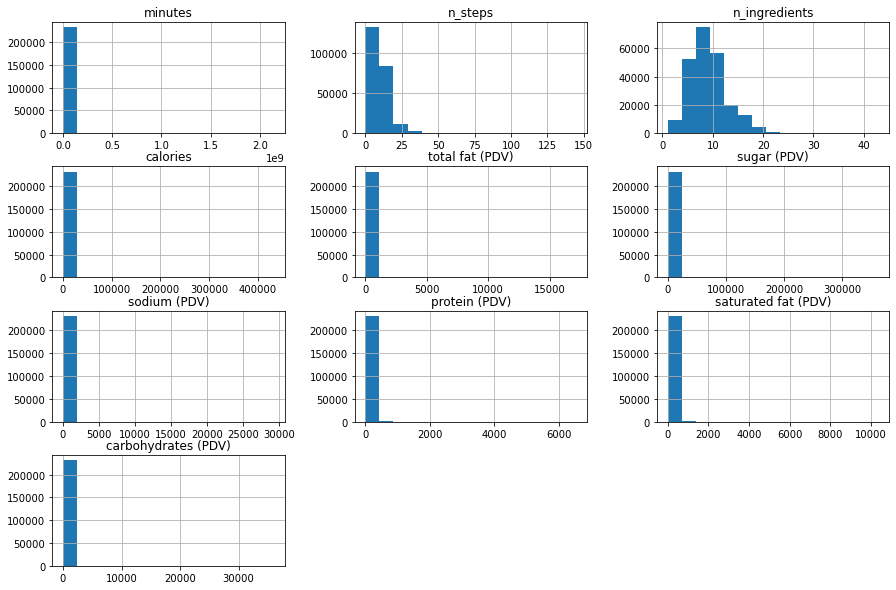

In [7]:
#Histograms for numerical features
recipes_df.drop(['recipe_id','contributor_id'], axis = 1).hist(bins = 15, figsize = (15, 10))
plt.show()

In [8]:
recipes_df.describe()

,recipe_id,minutes,contributor_id,n_steps,n_ingredients,calories,total fat (PDV),sugar (PDV),sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV)
count,231637.000000,2.316370e+05,2.316370e+05,231637.000000,231637.000000,231637.000000,231637.00000,231637.000000,231637.000000,231637.00000,231637.000000,231637.000000
mean,222014.708984,9.398546e+03,5.534885e+06,9.765499,9.051153,473.942425,36.08070,84.296865,30.147485,34.68186,45.589150,15.560403
std,141206.635626,4.461963e+06,9.979141e+07,5.995128,3.734796,1189.711374,77.79884,800.080897,131.961589,58.47248,98.235758,81.824560
min,38.000000,0.000000e+00,2.700000e+01,0.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,99944.000000,2.000000e+01,5.690500e+04,6.000000,6.000000,174.400000,8.00000,9.000000,5.000000,7.00000,7.000000,4.000000
50%,207249.000000,4.000000e+01,1.736140e+05,9.000000,9.000000,313.400000,20.00000,25.000000,14.000000,18.00000,23.000000,9.000000
75%,333816.000000,6.500000e+01,3.982750e+05,12.000000,11.000000,519.700000,41.00000,68.000000,33.000000,51.00000,52.000000,16.000000
max,537716.000000,2.147484e+09,2.002290e+09,145.000000,43.000000,434360.200000,17183.00000,362729.000000,29338.000000,6552.00000,10395.000000,36098.000000


The maximum values for all the numerical columns (except `recipe_id`, `contributor_id`) appear to be unrealistically high. The minimum value for `minutes`, `n_steps` and `calories` is 0; this also seems infeasible and is causing the distributions to be skewed.  We will therefore remove any infeasible 0 values, including recipes where *all* of the nutrtion values are 0 (it is possible for some/any of these values to be 0, but not all simultaneously) and any observations that are more than 1.5 IQR above Q3 in each column (except `recipe_id` and `contributor_id`).

In [9]:
recipes_df_filtered = recipes_df.copy()

#Removing any rows where calories, minutes, n_ingredients, and n_steps are 0
recipes_df_filtered = recipes_df_filtered[(recipes_df_filtered['calories'] != 0) &
                                          (recipes_df_filtered['minutes'] != 0) &
                                          (recipes_df_filtered['n_steps'] != 0)]

#Removing the rows where all nutritional values are 0 simultaneously
recipes_df_filtered = recipes_df_filtered[(recipes_df_filtered[nutrition_columns] != 0).any(axis = 1)]

In [10]:
#Finding the numerical columns
numerical_columns = recipes_df.select_dtypes(include = ['number']).drop(['recipe_id','contributor_id'], axis = 1).columns.tolist()

#Calculating the 25th and 75th percentiles of all numerical columns to compute the IQR
Q1 = recipes_df_filtered[numerical_columns].quantile(0.25)
Q3 = recipes_df_filtered[numerical_columns].quantile(0.75)

#Calculating IQR for each column
IQR = Q3 - Q1

#Defining the upper limit as 1.5 times the IQR above Q3
upper_limit = Q3 + 1.5 * IQR

#Filtering out recipes with values above the upper limit for outlier handling
for col in numerical_columns:
    recipes_df_filtered = recipes_df_filtered[~(recipes_df_filtered[col] > upper_limit[col])]

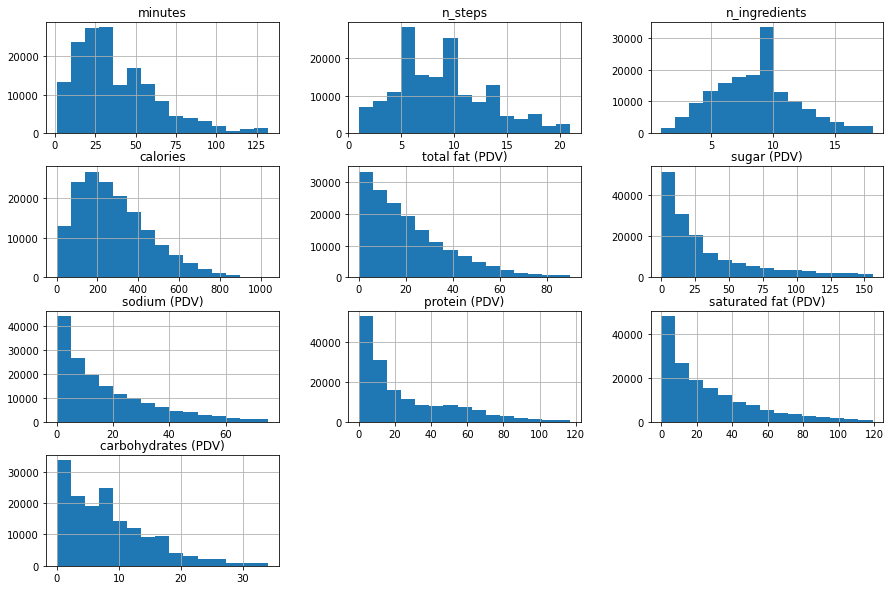

In [11]:
#Histograms for numerical features
recipes_df_filtered.drop(['recipe_id','contributor_id'], axis = 1).hist(bins = 15, figsize = (15, 10))
plt.show()

In [12]:
recipes_df_filtered.describe()

,recipe_id,minutes,contributor_id,n_steps,n_ingredients,calories,total fat (PDV),sugar (PDV),sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV)
count,158826.000000,158826.000000,1.588260e+05,158826.000000,158826.000000,158826.000000,158826.000000,158826.000000,158826.000000,158826.000000,158826.000000,158826.000000
mean,225657.559531,37.667208,4.782267e+06,8.724963,8.635689,280.118173,20.610020,33.021363,16.678548,24.648175,25.339252,8.446722
std,139954.430947,25.562026,9.217519e+07,4.307644,3.297759,174.909059,17.714988,35.673637,16.425874,25.275568,25.366144,6.829841
min,45.000000,1.000000,2.700000e+01,1.000000,1.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,104812.500000,20.000000,5.810400e+04,6.000000,6.000000,144.600000,7.000000,8.000000,4.000000,5.000000,6.000000,3.000000
50%,213700.500000,30.000000,1.851050e+05,8.000000,8.000000,250.400000,16.000000,19.000000,11.000000,14.000000,17.000000,7.000000
75%,336501.750000,50.000000,4.149230e+05,11.000000,11.000000,385.200000,30.000000,46.000000,25.000000,39.000000,38.000000,12.000000
max,537716.000000,132.000000,2.002285e+09,21.000000,18.000000,1034.800000,90.000000,156.000000,75.000000,117.000000,119.000000,34.000000


In [13]:
recipes_df_filtered.shape

(158826, 18)

In [14]:
recipes_df_filtered.head(3)

,name,recipe_id,minutes,contributor_id,submitted,tags,n_steps,steps,description,ingredients,n_ingredients,calories,total fat (PDV),sugar (PDV),sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV)
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7,51.5,0.0,13.0,0.0,2.0,0.0,4.0
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6,173.4,18.0,0.0,17.0,22.0,35.0,1.0
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13,269.8,22.0,32.0,48.0,39.0,27.0,5.0


In [15]:
print('The filtered recipes dataset has', recipes_df_filtered['recipe_id'].nunique(), 'unique recipes.')

The filtered recipes dataset has 158826 unique recipes.


## <a name = Reviews style="color:#000000;"> Reviews Data </a>

In [16]:
reviews_df.shape

(1132367, 5)

In [17]:
reviews_df.head(3)

,user_id,recipe_id,date,rating,review
0,38094,40893,2003-02-17,4,Great with a salad. Cooked on top of stove for...
1,1293707,40893,2011-12-21,5,"So simple, so delicious! Great for chilly fall..."
2,8937,44394,2002-12-01,4,This worked very well and is EASY. I used not...


In [18]:
#Checking unique values
print('The reviews dataset has', reviews_df['recipe_id'].nunique(), 'unique recipes,',
      reviews_df['user_id'].nunique(), 'unique users and', reviews_df['rating'].nunique(), 'unique ratings.')

The reviews dataset has 231637 unique recipes, 226570 unique users and 6 unique ratings.


In [19]:
reviews_df.describe()

,user_id,recipe_id,rating
count,1.132367e+06,1.132367e+06,1.132367e+06
mean,1.384291e+08,1.608972e+05,4.411016e+00
std,5.014269e+08,1.303987e+05,1.264752e+00
min,1.533000e+03,3.800000e+01,0.000000e+00
25%,1.354700e+05,5.425700e+04,4.000000e+00
50%,3.309370e+05,1.205470e+05,5.000000e+00
75%,8.045500e+05,2.438520e+05,5.000000e+00
max,2.002373e+09,5.377160e+05,5.000000e+00


The rating values of 0 represent where a recipe hasn't been rated. We will therefore remove these observations.

In [20]:
#Removing rows where rating is 0 (no rating)
reviews_df_filtered = reviews_df[reviews_df['rating'] != 0]

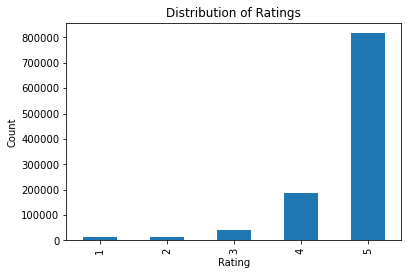

In [21]:
#Bar plot for the distribution of ratings
reviews_df_filtered['rating'].value_counts().sort_index().plot(kind = 'bar')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

The majority of recipes are given a rating of 5. 

In [22]:
print('The filtered reviews dataset has', reviews_df_filtered['recipe_id'].nunique(), 'unique recipes,',
      reviews_df_filtered['user_id'].nunique(), 'unique users and', 
      reviews_df_filtered['rating'].nunique(), 'unique ratings.')

The filtered reviews dataset has 226590 unique recipes, 196098 unique users and 5 unique ratings.


## <a name = 'Process Data for Knowledge Based Filtering' style="color:#000000;"> Process Data for Knowledge Based Filtering </a>

In [23]:
#Joining Pre-Processed Data with corresponding Review Data
merged_df = pd.merge(recipes_df_filtered, reviews_df_filtered, on = 'recipe_id', how = 'inner')

In [24]:
#Aggregating Ratings for each Recipe
agg_ratings_byrecipe = merged_df.groupby('recipe_id').agg(mean_rating = ('rating', 'mean'),
                                                          number_of_ratings = ('rating', 'count')).reset_index()

In [25]:
#Adding the average rating and number of rating to the filtered recipe data
KB_df = pd.merge(recipes_df_filtered, agg_ratings_byrecipe, on='recipe_id', how='inner')

In [26]:
KB_df.shape

(155806, 20)

In [27]:
KB_df.head(3)

,name,recipe_id,minutes,contributor_id,submitted,tags,n_steps,steps,description,ingredients,n_ingredients,calories,total fat (PDV),sugar (PDV),sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV),mean_rating,number_of_ratings
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7,51.5,0.0,13.0,0.0,2.0,0.0,4.0,5.000000,3
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6,173.4,18.0,0.0,17.0,22.0,35.0,1.0,4.666667,3
2,all in the kitchen chili,112140,130,196586,2005-02-25,"['time-to-make', 'course', 'preparation', 'mai...",6,"['brown ground beef in large pot', 'add choppe...",this modified version of 'mom's' chili was a h...,"['ground beef', 'yellow onions', 'diced tomato...",13,269.8,22.0,32.0,48.0,39.0,27.0,5.0,4.000000,1


In [28]:
#Converting all NaN to empty lists
KB_df['ingredients'] = KB_df['ingredients'].fillna('[]')

#Convert empty list string to object
KB_df['ingredients'] = KB_df['ingredients'].apply(literal_eval)

#Converting list to lowercase
KB_df['ingredients'] = KB_df['ingredients'].apply(lambda x: [ingredient.lower() for ingredient in x] if isinstance(x, list) else [])

#Creating new feature
s = KB_df.apply(lambda x: pd.Series(x['ingredients']), axis = 1).stack().reset_index(level = 1, drop = True)

#Renaming 'name' to 'ingredient'
s.name = 'ingredient'

#Joining s into KB_df
KB_df = KB_df.join(s)

In [29]:
KB_df.head(3)

,name,recipe_id,minutes,contributor_id,submitted,tags,n_steps,steps,description,ingredients,...,calories,total fat (PDV),sugar (PDV),sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV),mean_rating,number_of_ratings,ingredient
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"[winter squash, mexican seasoning, mixed spice...",...,51.5,0.0,13.0,0.0,2.0,0.0,4.0,5.0,3,winter squash
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"[winter squash, mexican seasoning, mixed spice...",...,51.5,0.0,13.0,0.0,2.0,0.0,4.0,5.0,3,mexican seasoning
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"[winter squash, mexican seasoning, mixed spice...",...,51.5,0.0,13.0,0.0,2.0,0.0,4.0,5.0,3,mixed spice


In [30]:
KB_df.shape

(1345320, 21)

In [31]:
print('The knowledge base filtering dataset has', KB_df['recipe_id'].nunique(), 'unique recipes.')

The knowledge base filtering dataset has 155806 unique recipes.


## <a name = 'Process Data for Collaborative Filtering' style="color:#000000;"> Process Data for Collaborative Filtering </a>

In [32]:
#Counting the number of ratings for each recipe
recipes_numberofratings = reviews_df_filtered['recipe_id'].value_counts()

#Filtering Recipes with 20+ ratings
popular_recipes = recipes_numberofratings[recipes_numberofratings >= 20].index.tolist()

In [33]:
#Counting the number of recipes rated by each user
users_numberofratings = reviews_df_filtered['user_id'].value_counts()

#Filtering Recipes with 20+ ratings
active_users = users_numberofratings[users_numberofratings >= 20].index.tolist()

In [34]:
#Only keeping observations where the recipe has 20+ rating and the user has rated 20+ recipes
reviews_df_filteredforCF = reviews_df_filtered[reviews_df_filtered['recipe_id'].isin(popular_recipes) &
                                reviews_df_filtered['user_id'].isin(active_users)]

In [35]:
#Joining recipes_df_filtered and reviews_df_filteredforCF
CF_df = pd.merge(recipes_df_filtered, reviews_df_filteredforCF, on = 'recipe_id', how = 'inner')

In [36]:
#Joining agg_ratings_byrecipe so the dataset includes mean rating and number of rating per recipe
CF_df = pd.merge(CF_df, agg_ratings_byrecipe, on = 'recipe_id', how = 'inner')

In [37]:
CF_df.shape

(152009, 24)

In [38]:
CF_df.head(3)

,name,recipe_id,minutes,contributor_id,submitted,tags,n_steps,steps,description,ingredients,...,sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV),user_id,date,rating,review,mean_rating,number_of_ratings
0,how i got my family to eat spinach spinach ca...,25775,50,37305,2002-04-22,"['60-minutes-or-less', 'time-to-make', 'course...",5,"['preheat oven to 350 degrees', 'place spinach...","if spinach scares you, this is one recipe that...","['frozen chopped spinach', 'egg', 'salt', 'bla...",...,32.0,19.0,26.0,3.0,112080,2006-12-15,4,The recipe was good but too salty. I agree wi...,4.342593,108
1,how i got my family to eat spinach spinach ca...,25775,50,37305,2002-04-22,"['60-minutes-or-less', 'time-to-make', 'course...",5,"['preheat oven to 350 degrees', 'place spinach...","if spinach scares you, this is one recipe that...","['frozen chopped spinach', 'egg', 'salt', 'bla...",...,32.0,19.0,26.0,3.0,29956,2002-04-23,3,"It was alright, but won't be rushing out to ma...",4.342593,108
2,how i got my family to eat spinach spinach ca...,25775,50,37305,2002-04-22,"['60-minutes-or-less', 'time-to-make', 'course...",5,"['preheat oven to 350 degrees', 'place spinach...","if spinach scares you, this is one recipe that...","['frozen chopped spinach', 'egg', 'salt', 'bla...",...,32.0,19.0,26.0,3.0,57828,2002-12-01,4,Great way to make spinach that doesn't taste t...,4.342593,108


In [39]:
print('The collaborative filtering dataset has', CF_df['recipe_id'].nunique(), 'unique recipes and',
      CF_df['user_id'].nunique(), 'unique users.')

The collaborative filtering dataset has 5008 unique recipes and 6419 unique users.


## <a name = 'Process Data for Content Based Filtering' style="color:#000000;">Process Data for Content Based Filtering </a>

In [40]:
#Using the same recipes from the collaborative filtering dataset, but removing the reviews/ratings related data
CB_df = CF_df.drop(['user_id','date','rating','review'], axis = 1).drop_duplicates()

In [41]:
CB_df.head(3)

,name,recipe_id,minutes,contributor_id,submitted,tags,n_steps,steps,description,ingredients,n_ingredients,calories,total fat (PDV),sugar (PDV),sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV),mean_rating,number_of_ratings
0,how i got my family to eat spinach spinach ca...,25775,50,37305,2002-04-22,"['60-minutes-or-less', 'time-to-make', 'course...",5,"['preheat oven to 350 degrees', 'place spinach...","if spinach scares you, this is one recipe that...","['frozen chopped spinach', 'egg', 'salt', 'bla...",8,166.1,16.0,6.0,32.0,19.0,26.0,3.0,4.342593,108
51,immoral sandwich filling loose meat,58224,35,37183,2003-04-04,"['60-minutes-or-less', 'time-to-make', 'course...",6,"['brown the meat & drain fat', 'stir in sugar ...",just the thing for a day when you're wanton so...,"['ground beef', 'sugar', 'prepared yellow must...",8,223.2,22.0,4.0,7.0,35.0,30.0,0.0,4.200000,20
67,land of nod cinnamon buns,22526,35,29212,2002-03-14,"['60-minutes-or-less', 'time-to-make', 'course...",7,"['before you turn in for the night , grease a ...",i have made this several times and it's dead e...,"['rolls', 'brown sugar', 'instant vanilla pudd...",6,575.3,18.0,116.0,34.0,28.0,22.0,34.0,4.734694,49


In [42]:
CB_df.shape

(5008, 20)

In [43]:
print('The content based filtering dataset has', CB_df['recipe_id'].nunique(), 'unique recipes.')

The content based filtering dataset has 5008 unique recipes.


# <a name = 'Content Based Filtering' style="color:#000000;">Content Based Filtering </a>

In [44]:
def CB_recommendations(CB_df, recipe_id, num_recs):
    text_data = CB_df['steps'].tolist()
    
    #Creating TfidfVectorizer object
    tfidf = TfidfVectorizer()
    
    #Computing sparse matrix with words
    tfidf_matrix = tfidf.fit_transform(text_data)
    
    recipe = recipes_df.loc[recipes_df['recipe_id'] == recipe_id]
    ingredients = recipe['ingredients'].values[0] if isinstance(recipe['ingredients'].values[0], list) else ast.literal_eval(recipe['ingredients'].values[0])
    ingredients_str = ', '.join(ingredients)
    
    #Computing TF-IDF matrix
    new_query = ingredients_str
    new_query_vector = tfidf.transform([new_query])

    #Computing cosine similarity
    cosine_sim = pd.DataFrame(cosine_similarity(tfidf_matrix, new_query_vector), columns = ['cosine_similarity_score'], index = CB_df.index)

    #Ranking cosine similarity - desciending
    cosine_sim = cosine_sim.sort_values(by = ['cosine_similarity_score'], ascending = False)

    recipe_recomm = CB_df.loc[cosine_sim.index[1: num_recs + 1],:]
    return recipe_recomm

In [45]:
#Generating a random recipe_id
recipe_id = recipes_df_filtered.recipe_id.sample().tolist()[0]
recipes_df_filtered[recipes_df_filtered['recipe_id']==recipe_id]

,name,recipe_id,minutes,contributor_id,submitted,tags,n_steps,steps,description,ingredients,n_ingredients,calories,total fat (PDV),sugar (PDV),sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV)
55024,clean eating tuna casserole,453978,45,992845,2011-04-19,"['60-minutes-or-less', 'time-to-make', 'course...",15,"['preheat oven to 350f', 'bring a large stockp...",from an old copy of clean eating magazine. we ...,"['whole wheat macaroni', 'carrots', 'olive oil...",14,371.3,7.0,14.0,21.0,66.0,6.0,16.0


In [46]:
CB_recommendations(CB_df, recipe_id, 5)

,name,recipe_id,minutes,contributor_id,submitted,tags,n_steps,steps,description,ingredients,n_ingredients,calories,total fat (PDV),sugar (PDV),sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV),mean_rating,number_of_ratings
37342,cold macaroni tuna salad,26085,90,37779,2002-04-22,"['weeknight', 'time-to-make', 'course', 'main-...",8,['cook macaroni according to package direction...,this is the answer for me on a hot summer day....,"['hard-boiled eggs', 'macaroni', 'frozen green...",7,574.4,15.0,36.0,15.0,83.0,13.0,25.0,4.741935,31
12306,banana pancakes eggless,14130,20,12657,2001-11-12,"['30-minutes-or-less', 'time-to-make', 'course...",5,"['in a large bowl , mix all-purpose flour , wh...",it's really hard to find a recipe for eggless ...,"['all-purpose flour', 'whole wheat flour', 'sa...",7,91.5,0.0,11.0,5.0,6.0,0.0,6.0,4.454545,33
53359,ethiopian tomato cucumber salad,454644,15,171790,2011-04-28,"['weeknight', '15-minutes-or-less', 'time-to-m...",2,['toss together all ingredients except olive o...,from homemakers magazine\r\nserve with ethiopi...,"['tomatoes', 'cucumbers', 'sweet onion', 'hot ...",9,54.2,3.0,18.0,6.0,2.0,1.0,2.0,4.800000,25
86839,low fat high fiber blueberry bran muffins,205891,25,307059,2007-01-16,"['30-minutes-or-less', 'time-to-make', 'course...",10,"['preheat oven to 375 degrees', 'grease muffin...",these muffins are a great low-fat moist muffin...,"['wheat bran', 'nonfat milk', 'unsweetened app...",12,98.4,1.0,48.0,8.0,5.0,0.0,7.0,4.678571,28
47633,dijon chicken with panko crust,85475,30,49304,2004-03-02,"['30-minutes-or-less', 'time-to-make', 'course...",7,"['in a large bowl , whisk together butter , mu...","this is a very good and tasty recipe, takes on...","['butter', 'dijon mustard', 'garlic', 'panko b...",10,589.0,48.0,12.0,48.0,109.0,54.0,6.0,4.763158,38


# <a name = 'Knowledge Based Filtering (with Content-Based Integrated)' style="color:#000000;"> Knowledge Based Filtering (with Content-Based Integrated) </a>

In [47]:
def knowledge_based(KB_df, percentile = 0.8):
    
    #Series of questions to ask the user their preferences 
    ingredients_preference = get_boolean_preference("\nDo you have a preference on ingredients? (yes/no):")
    preferred_ingredients = None
    include_all_ingredients = False

    if ingredients_preference == 'yes':
        preferred_ingredients = get_preferred_ingredients()
        include_all_ingredients = get_boolean_preference("\nShould the recipes include all of these ingredients? (yes/no):")

    matching_recipes = filter_recipes_by_ingredients(KB_df, preferred_ingredients, include_all_ingredients)
    
    time_limited = get_boolean_preference("\nAre you limited for time? (yes/no):")
    
    max_time = None
    if time_limited == 'yes':
        max_time = get_numeric_preference("\nHow long do you have in minutes?", "\nInvalid input. Please enter a valid numerical value for time.")
    
    cals_limited = get_boolean_preference("\nWould you like to limit calorie intake? (yes/no):")
    
    max_cals = None
    if cals_limited == 'yes':
        max_cals = get_numeric_preference("\nWhat is your maximum preferred calories?", "\nInvalid input. Please enter a valid numerical value for calories.")

    preference = get_user_preference("\nWould you prefer a recipe with: \n1. fewer steps \n2. fewer ingredients \n3. less time required \n4. the highest rating \n5. lower calories \n6. higher calories \n7. specific nutritional preferences? \nPlease select from options 1-7 (enter the number):", ['1', '2', '3', '4', '5', '6', '7'])
    
    filters = [('time', max_time), ('calories', max_cals)]
    recipes = apply_filters(matching_recipes, max_time, max_cals)
    
    if preference == '7':
        print("\nEnter your specific nutritional preferences, separated by commas (e.g. sodium (low), protein (high)).\nYou can choose from: \n-total fat \n-saturated fat \n-sugar \n-sodium \n-protein \n-carbohydrates")
        nutritional_preferences = input().lower().split(',')
        recommendations = calculate_and_sort_scores(recipes, KB_df['number_of_ratings'].quantile(percentile), percentile, preference, nutritional_preferences)
    else:
        recommendations = calculate_and_sort_scores(recipes, KB_df['number_of_ratings'].quantile(percentile), percentile, preference)
    

    if not recommendations.empty:
        recommendations = recommendations.drop_duplicates(subset=['recipe_id']).copy()
        num_recommendations = get_num_recommendations()    
        display_recommendations(recommendations, num_recommendations)
        # Ask the user if they want to see a recipe in more detail
        user_option = get_user_preference("\nWould you like to:\n1. see a recipe in more detail\n2. see recipes similar to one of the recommendations \n3. Quit \nPlease select option 1, 2 or 3:", ['1', '2', '3'])

        if user_option == '1':
            recipe_id = get_numeric_preference("\nEnter the recipe ID:")
            display_single_recipe(recipe_id, KB_df)
            user_pref = get_boolean_preference("\nWould you like to see recipes similar to this? (yes/no):")
            if user_pref == 'yes':
                CB_result = CB_recommendations(CB_df, recipe_id, 5)
                display_recommendations(CB_result, 5)
        elif user_option == '2':
            recipe_id = get_numeric_preference("\nEnter the recipe ID to see similar recipes:")
            CB_result = CB_recommendations(CB_df, recipe_id, 5)
            display_recommendations(CB_result, 5)
            user_pref = get_boolean_preference("\nWould you like to see a recipe in more detail? (yes/no):")
            if user_pref == 'yes':
                recipe_id = get_numeric_preference("\nEnter the recipe ID:")
                display_single_recipe(recipe_id, CF_df)
            else:
                print('We hope you like our recommendations!')             
        else:
            print('We hope you like our recommendations!')
    else:
        print("\nSorry, we couldn't find you any recommendations.")
        
        
#Asking user for their preferences - ensuring validity of respose        
def get_user_preference(prompt, valid_responses):
    while True:
        print(prompt)
        response = input().lower()
        if response in valid_responses:
            return response
        else:
            print(f"\nInvalid response. Please enter one of: {', '.join(valid_responses)}")

#Asking user for prefered ingredients
def get_preferred_ingredients():
    print("\nPlease enter preferred ingredients separated by commas (e.g., ingredient1,ingredient2):")
    return [ingredient.strip() for ingredient in input().lower().split(',')]

#Asking for yes/no response
def get_boolean_preference(prompt):
    return get_user_preference(prompt, ['yes', 'no'])

#Asking for numeric response
def get_numeric_preference(prompt, error_message="\nInvalid input. Please enter a valid numerical value."):
    while True:
        try:
            print(prompt)
            return int(input())
        except ValueError:
            print(error_message)

#Asking how many preferred recomendations user desires
def get_num_recommendations():
    num_recs = get_numeric_preference("\nWhat is the maximum number of recommendations you'd like to receive? Enter a numerical value:", "Invalid input. Please enter a valid numerical value for the number of recommendations.")
    return num_recs

#Filtering recipe based on ingredients - KB
def filter_recipes_by_ingredients(KB_df, preferred_ingredients, include_all_ingredients):
    if preferred_ingredients:
        if not include_all_ingredients:
            matching_recipes = KB_df[KB_df['ingredients'].apply(
                lambda x: any(ingredient in set(map(str.strip, x)) for ingredient in preferred_ingredients)
            )]
        else:
            matching_recipes = KB_df[KB_df['ingredients'].apply(
                lambda x: set(preferred_ingredients).issubset(set(map(str.strip, x)))
            )]

        if not matching_recipes.empty:
            return matching_recipes

        print("\nNo recipes found with all specified ingredients.")
        include_at_least_one = get_boolean_preference("\nAre you okay with recommendations that only include some of your preferred ingredients? (yes/no):")
        if include_at_least_one == 'yes':
            matching_recipes = KB_df[KB_df['ingredients'].apply(
                lambda x: any(ingredient in set(map(str.strip, x)) for ingredient in preferred_ingredients)
            )]
            return matching_recipes

        return pd.DataFrame()
    else:
        return KB_df.copy()

#Applying filter on minutes and calories
def apply_filters(KB_df, max_time = None, max_cals = None):
    if max_time:
        KB_df = KB_df[KB_df['minutes'] <= max_time]
    if max_cals:
        KB_df = KB_df[KB_df['calories'] <= max_cals]
    return KB_df

#Calculating and sorting score per recipe
def calculate_and_sort_scores(KB_df, m, percentile, preference, nutritional_preferences=None):
    C = KB_df['mean_rating'].mean()
    q_recipes = KB_df.loc[KB_df['number_of_ratings'] >= m]

    if not q_recipes.empty:
        q_recipes = q_recipes.copy()
        q_recipes['score'] = q_recipes.apply(lambda x: calculate_score(x, C, m, preference, nutritional_preferences), axis=1)
        q_recipes = q_recipes.sort_values('score', ascending=False)
        return q_recipes
    else:
        print("\nNo recipes found based on the specified criteria.")
        return pd.DataFrame()

#Calculating score based on resipe and preferences
def calculate_score(recipe, C, m, preference, nutritional_preferences=None):
    if preference == '1':
        return -recipe['n_steps'] + (recipe['number_of_ratings'] / (recipe['number_of_ratings'] + m) * recipe['mean_rating']) + (m / (m + recipe['number_of_ratings']) * C)
    elif preference == '2':
        return -recipe['n_ingredients'] + (recipe['number_of_ratings'] / (recipe['number_of_ratings'] + m) * recipe['mean_rating']) + (m / (m + recipe['number_of_ratings']) * C)
    elif preference == '3':
        return -recipe['minutes'] + (recipe['number_of_ratings'] / (recipe['number_of_ratings'] + m) * recipe['mean_rating']) + (m / (m + recipe['number_of_ratings']) * C)
    elif preference == '4':
        return (recipe['number_of_ratings'] / (recipe['number_of_ratings'] + m) * recipe['mean_rating']) + (m / (m + recipe['number_of_ratings']) * C)
    elif preference == '5':
        return -recipe['calories'] + (recipe['number_of_ratings'] / (recipe['number_of_ratings'] + m) * recipe['mean_rating']) + (m / (m + recipe['number_of_ratings']) * C)
    elif preference == '6':
        return recipe['calories'] + (recipe['number_of_ratings'] / (recipe['number_of_ratings'] + m) * recipe['mean_rating']) + (m / (m + recipe['number_of_ratings']) * C)
    elif preference == '7':
        
        return calculate_nutritional_score(recipe, C, m, nutritional_preferences)
    else:
        return 0

#Calculating nutrional score
def calculate_nutritional_score(recipe, C, m, nutritional_preferences):
    score = 0
    for pref in nutritional_preferences:
        nutrient, condition = [part.strip() for part in pref.split('(')]
        condition = condition[:-1]
        column_name = f"{nutrient} (PDV)"
        if column_name in recipe.index:
            if condition == 'low':
                score += -recipe[column_name] + (recipe['number_of_ratings'] / (recipe['number_of_ratings'] + m) * recipe['mean_rating']) + (m / (m + recipe['number_of_ratings']) * C)
            elif condition == 'high':
                score += recipe[column_name] + (recipe['number_of_ratings'] / (recipe['number_of_ratings'] + m) * recipe['mean_rating']) + (m / (m + recipe['number_of_ratings']) * C)
        else:
            print(f"\nNutrient '{column_name}' not found. Ignoring nutritional preference.")
            break
    return score

#Displaying recipe formatting
def display_single_recipe(recipe_id, df):
    #Locating the specific recipe
    recipe = df.loc[df['recipe_id'] == recipe_id]

    if not recipe.empty:
        #Removing uneeded info
        title = recipe['name'].values[0]
        ingredients = recipe['ingredients'].values[0] if isinstance(recipe['ingredients'].values[0], list) else ast.literal_eval(recipe['ingredients'].values[0])
        time = recipe['minutes'].values[0]
        nutritional_info = get_nutritional_info(recipe)
        method = format_recipe_steps(recipe['steps'].values[0])

        #Displaying info using print statements
        print(f"\nRecipe: {title}\n")
        print("Ingredients:")
        for ingredient in ingredients:
            print(f"- {ingredient}")
        print(f"\nTime: {time} minutes\n")
        print("Nutritional Information:")
        print(nutritional_info)
        print("\nMethod:")
        print(method)
    else:
        print(f"\nNo recipe found with the given ID: {recipe_id}")

#Formatting recipe
def format_recipe_steps(steps):
    steps_list = ast.literal_eval(steps)
    formatted_steps = "\n".join([f"Step {i+1}: {step}" for i, step in enumerate(steps_list)])
    return formatted_steps

#Getting nutritional information
def get_nutritional_info(recipe):
    calories = recipe['calories'].values[0]
    total_fat_pdv = recipe['total fat (PDV)'].values[0]
    sugar_pdv = recipe['sugar (PDV)'].values[0]
    sodium_pdv = recipe['sodium (PDV)'].values[0]
    protein_pdv = recipe['protein (PDV)'].values[0]
    saturated_fat_pdv = recipe['saturated fat (PDV)'].values[0]
    carbohydrates_pdv = recipe['carbohydrates (PDV)'].values[0]

    #Formatting
    table = f"Calories: {calories}\n" \
            f"Total Fat (PDV): {total_fat_pdv}\n" \
            f"Sugar (PDV): {sugar_pdv}\n" \
            f"Sodium (PDV): {sodium_pdv}\n" \
            f"Protein (PDV): {protein_pdv}\n" \
            f"Saturated Fat (PDV): {saturated_fat_pdv}\n" \
            f"Carbohydrates (PDV): {carbohydrates_pdv}"

    return table

#Displaying recomendations
def display_recommendations(recommendations, num_recommendations):
    if not recommendations.empty:
        recommendations.loc[:, 'ingredients'] = recommendations['ingredients'].astype(str)
        display_cols = ['name','recipe_id','minutes','steps','ingredients','calories','total fat (PDV)','sugar (PDV)','sodium (PDV)','protein (PDV)', 'saturated fat (PDV)', 'carbohydrates (PDV)', 'mean_rating', 'number_of_ratings']
        recommendations = recommendations[display_cols].head(num_recommendations)
        max_colwidth = len(max(recommendations['ingredients'], key=len))
        pd.set_option('display.max_colwidth', max_colwidth)    
        display(recommendations)

In [49]:
knowledge_based(KB_df, percentile = 0.8)


Do you have a preference on ingredients? (yes/no):
yes

Please enter preferred ingredients separated by commas (e.g., ingredient1,ingredient2):
chicken,bacon

Should the recipes include all of these ingredients? (yes/no):
yes

Are you limited for time? (yes/no):
yes

How long do you have in minutes?
45

Would you like to limit calorie intake? (yes/no):
no

Would you prefer a recipe with: 
1. fewer steps 
2. fewer ingredients 
3. less time required 
4. the highest rating 
5. lower calories 
6. higher calories 
7. specific nutritional preferences? 
Please select from options 1-7 (enter the number):
7

Enter your specific nutritional preferences, separated by commas (e.g. sodium (low), protein (high)).
You can choose from: 
-total fat 
-saturated fat 
-sugar 
-sodium 
-protein 
-carbohydrates
protein(high),sodium(low)

What is the maximum number of recommendations you'd like to receive? Enter a numerical value:
5


,name,recipe_id,minutes,steps,ingredients,calories,total fat (PDV),sugar (PDV),sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV),mean_rating,number_of_ratings
138127,sweet n spicy bacon chicken,333452,30,"['preheat oven to 350 degrees fahrenheit', 'slice chicken into bite-sized pieces', 'cut bacon into 1 to 1-1 / 2 inch pieces', 'wrap a piece of bacon around each chicken piece', 'use toothpicks if necessary', '...","['chicken', 'bacon', 'brown sugar', 'cayenne pepper']",609.4,65.0,106.0,23.0,55.0,67.0,9.0,5.000,7
16904,blt barbecue chicken salad,459616,10,"['in a small bowl , mix the mayo , bbq sauce , onion , lemon juice , and pepper', 'cover & refrigerate until ready to serve', 'place salad greens on a large serving platter , add tomatoes , chicken , bacon and...","['mayonnaise', 'barbecue sauce', 'onions', 'lemon juice', 'pepper', 'chicken', 'bacon', 'hard-boiled eggs', 'salad greens', 'tomatoes']",331.6,36.0,17.0,13.0,39.0,31.0,3.0,4.800,5
28747,chicken and bacon pan fried sandwich,434019,26,"['place the bacon under a preheated hot grill and cook for 1-2 minutes or until crispy', 'place the maonnaise , garlic , lemon juice , chives and chicken in a bowl and mix well to combine', 'spread both sides ...","['bacon', 'mayonnaise', 'garlic cloves', 'lemon juice', 'chives', 'chicken', 'butter', 'sourdough bread', 'smoked cheddar cheese']",673.0,43.0,15.0,47.0,61.0,74.0,24.0,4.875,8
104780,pear blue cheese walnut and bacon salad,476046,23,"['whisk together all vinaigrette ingredients until well blended', 'set aside', 'in a small frying pan set on a medium heat , melt the butter , stir in the maple syrup or honey and then stir in the walnuts', 'c...","['olive oil', 'limes', 'white wine vinegar', 'dijon mustard', 'maple syrup', 'green onions', 'salt and pepper', 'walnut halves', 'butter', 'cayenne', 'arugula', 'bartlett pears', 'blue cheese', 'bacon', 'chick...",354.6,44.0,43.0,13.0,17.0,33.0,6.0,4.800,5
121680,sauteed swiss chard with bacon,362648,20,"['coat a large saute pan lightly with olive oil and add the diced bacon , garlic , and crushed red pepper', 'bring the pan to medium-high heat', 'when the garlic has turned a lovely golden brown , remove from ...","['olive oil', 'bacon', 'garlic cloves', 'crushed red pepper flakes', 'swiss chard', 'chicken', 'kosher salt']",20.5,0.0,4.0,8.0,3.0,0.0,1.0,5.000,6



Would you like to:
1. see a recipe in more detail
2. see recipes similar to one of the recommendations 
3. Quit 
Please select option 1, 2 or 3:
2

Enter the recipe ID to see similar recipes:
476046


,name,recipe_id,minutes,steps,ingredients,calories,total fat (PDV),sugar (PDV),sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV),mean_rating,number_of_ratings
109990,potato salad with creamy blue cheese dressing,263131,20,"['peel potatoes if you wish , then cut into bite-size chunks', 'place in a large saucepan of salted water , set over high heat and bring to the boil', 'pa...","['potatoes', 'lemon juice', 'bacon', 'red pepper', 'green onions', 'mayonnaise', 'sour cream', 'hot pepper sauce', 'blue cheese', 'salt and pepper']",339.6,26.0,20.0,18.0,17.0,33.0,13.0,4.909091,22
132531,sweet potato pear soup,115291,85,"['melt the butter in a large pot over a medium heat , and saut onion for 2-3 minutes until softened but not brown', 'add the diced sweet potato and diced ...","['butter', 'yellow onions', 'sweet potatoes', 'pears', 'chicken broth', 'white wine', 'greek yogurt', 'of fresh mint']",223.7,5.0,70.0,26.0,12.0,8.0,14.0,4.727273,22
88173,maple glazed walnuts,253308,15,"['preheat a dry skillet over a medium-high heat', 'add the walnuts , maple syrup and salt', 'cook , stirring frequently , until syrup is caramelized and n...","['walnut halves', 'maple syrup', 'salt']",301.7,39.0,46.0,2.0,11.0,12.0,5.0,4.950000,20
85536,loaded baked potato chicken casserole,505862,90,"['preheat oven to 500 degrees', 'in large bowl mix olive oil , salt , pepper , paprika , garlic powder and hot sauce', 'add potatoes to bowl and allow to ...","['chicken breasts', 'potatoes', 'olive oil', 'salt', 'fresh ground pepper', 'paprika', 'garlic powder', 'hot sauce', 'cheddar cheese', 'bacon', 'green oni...",652.2,57.0,9.0,41.0,75.0,65.0,13.0,4.385965,57
7913,bacon wrapped smoked gouda stuffed chicken breasts,111169,30,"['combine , cayenne , garlic powder , paprika and pepper', 'flatten chicken breasts to approx 1 / 4"" thickness', 'season both sides of chicken with the ca...","['boneless chicken breasts', 'bacon', 'smoked gouda cheese', 'cayenne', 'garlic powder', 'paprika', 'pepper']",365.0,35.0,2.0,13.0,73.0,44.0,0.0,4.644444,45



Would you like to see a recipe in more detail? (yes/no):
yes

Enter the recipe ID:
111169

Recipe: bacon wrapped smoked gouda stuffed chicken breasts

Ingredients:
- boneless chicken breasts
- bacon
- smoked gouda cheese
- cayenne
- garlic powder
- paprika
- pepper

Time: 30 minutes

Nutritional Information:
Calories: 365.0
Total Fat (PDV): 35.0
Sugar (PDV): 2.0
Sodium (PDV): 13.0
Protein (PDV): 73.0
Saturated Fat (PDV): 44.0
Carbohydrates (PDV): 0.0

Method:
Step 1: combine , cayenne , garlic powder , paprika and pepper
Step 2: flatten chicken breasts to approx 1 / 4" thickness
Step 3: season both sides of chicken with the cayenne mixture
Step 4: place small piece of cheese on chicken and roll up , pressing firmly
Step 5: wrap each stuffed breast with a bacon slice and then brown over medium heat until bacon just begins to crisp
Step 6: bake in a 350 oven for 20 minutes


# <a name = 'Collaborative Filtering' style="color:#000000;"> Collaborative Filtering </a>

## <a name = 'Finding the Best Model' style="color:#000000;"> Finding the Best Model </a>

In [50]:
#Creating a Surprise Reader and Dataset
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(CF_df[['user_id', 'recipe_id', 'rating']], reader)

We will test different Matrix Factorization-based algorithms and k-NN inspired algorithms to determine which has the lowest rmse and which has the lowest mae when using the default parameters.

In [51]:
benchmark = []

#Iterating over all algorithms
for algorithm in [SVD(), SVDpp(), NMF(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore()]:
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['rmse','mae'], cv=3, verbose=False)
    
    #Getting results & appending algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp['Algorithm'] = str(algorithm).split(' ')[0].split('.')[-1]  # Add Algorithm column
    benchmark.append(tmp)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.


In [52]:
#Creating a DataFrame
df_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')
df_results

,test_rmse,test_mae,fit_time,test_time
Algorithm,,,,
SVDpp,0.561699,0.358153,5.774663,3.016644
SVD,0.564657,0.363648,0.993732,0.280666
KNNBaseline,0.592341,0.372180,1.284524,2.898323
KNNWithMeans,0.593640,0.367212,1.326875,2.672962
KNNWithZScore,0.607871,0.365559,1.484004,2.853422
KNNBasic,0.630617,0.391360,1.231344,2.634246
NMF,0.683163,0.533692,2.067042,0.293430


In [53]:
#Sorting the DataFrame by rmse
lowest_rmse_model = df_results.sort_values(by='test_rmse').index[0]
print(f"Model with the lowest RMSE: {lowest_rmse_model}")

#Sorting the DataFrame by mae
lowest_mae_model = df_results.sort_values(by='test_mae').index[0]
print(f"Model with the lowest MAE: {lowest_mae_model}")

Model with the lowest RMSE: SVDpp
Model with the lowest MAE: SVDpp


We will now tune the hyperparmaters of each model and test which has the lowest rmse.  

In [54]:
#Splitting the data into train and test
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

#Creating dictionary with algorithms as key
param_grid = {
    'KNNBasic': {'k': [20, 30, 40], 'sim_options': {'name': ['cosine', 'msd', 'pearson'], 'user_based': [True, False]}},
    'KNNWithMeans': {'k': [20, 30, 40], 'sim_options': {'name': ['cosine', 'msd', 'pearson'], 'user_based': [True, False]}},
    'KNNWithZScore': {'k': [20, 30, 40], 'sim_options': {'name': ['cosine', 'msd', 'pearson'], 'user_based': [True, False]}},
    'KNNBaseline': {'k': [20, 30, 40], 'sim_options': {'name': ['cosine', 'msd', 'pearson'], 'user_based': [True, False]}, 'bsl_options': {'method': ['als', 'sgd']}},
    'NMF': {'n_factors': [10, 20, 30], 'n_epochs': [50, 100, 150]},
    'SVD': {'n_factors': [50, 100, 150], 'n_epochs': [10, 20, 30], 'lr_all': [0.005, 0.01, 0.02], 'reg_all': [0.02, 0.1, 0.2]},
    'SVDpp': {'n_factors': [50, 100, 150], 'n_epochs': [10, 20, 30], 'lr_all': [0.005, 0.01, 0.02], 'reg_all': [0.02, 0.1, 0.2]}
}

#Iterating over all algorithms
results = []
for algo_name, param_grid_for_algo in param_grid.items():
    
    #GridSearchCV
    gs = GridSearchCV(eval(algo_name), param_grid_for_algo, measures=['rmse'], cv = 3, joblib_verbose = 1, n_jobs =- 1)
    gs.fit(data)
    
    #Geting best parameters
    best_params = gs.best_params['rmse']
    best_score = gs.best_score["rmse"]
    
    #Printing best parameters
    print(f"{algo_name} - Best Params: {best_params}")
    
    #Print test RMSE
    print(f"{algo_name} - RMSE: {best_score}")
    
    #Appending results to list
    results.append({'Algorithm': algo_name, 'Best_Params': best_params, 'RMSE': best_score})

#Converting list to DataFrame
results_df_rmse = pd.DataFrame(results)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  4.4min finished


KNNBasic - Best Params: {'k': 40, 'sim_options': {'name': 'cosine', 'user_based': False}}
KNNBasic - RMSE: 0.6083371308289406


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  3.6min finished


KNNWithMeans - Best Params: {'k': 40, 'sim_options': {'name': 'cosine', 'user_based': True}}
KNNWithMeans - RMSE: 0.593090388025554


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  3.5min finished


KNNWithZScore - Best Params: {'k': 40, 'sim_options': {'name': 'cosine', 'user_based': False}}
KNNWithZScore - RMSE: 0.601290907999905


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 108 out of 108 | elapsed: 10.7min finished


KNNBaseline - Best Params: {'k': 40, 'sim_options': {'name': 'cosine', 'user_based': True}, 'bsl_options': {'method': 'sgd'}}
KNNBaseline - RMSE: 0.5866029555187133


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed:   16.9s finished


NMF - Best Params: {'n_factors': 30, 'n_epochs': 100}
NMF - RMSE: 0.6050970619535835


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed:   44.5s finished


SVD - Best Params: {'n_factors': 50, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.2}
SVD - RMSE: 0.5589713462897995


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  6.4min


SVDpp - Best Params: {'n_factors': 50, 'n_epochs': 10, 'lr_all': 0.01, 'reg_all': 0.2}
SVDpp - RMSE: 0.5588569981319428


[Parallel(n_jobs=-1)]: Done 243 out of 243 | elapsed: 10.6min finished


In [55]:
#Displaying and sorting by RMSE
results_df_rmse.sort_values(by = 'RMSE')

,Algorithm,Best_Params,RMSE
6,SVDpp,"{'n_factors': 50, 'n_epochs': 10, 'lr_all': 0.01, 'reg_all': 0.2}",0.558857
5,SVD,"{'n_factors': 50, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.2}",0.558971
3,KNNBaseline,"{'k': 40, 'sim_options': {'name': 'cosine', 'user_based': True}, 'bsl_options': {'method': 'sgd'}}",0.586603
1,KNNWithMeans,"{'k': 40, 'sim_options': {'name': 'cosine', 'user_based': True}}",0.593090
2,KNNWithZScore,"{'k': 40, 'sim_options': {'name': 'cosine', 'user_based': False}}",0.601291
4,NMF,"{'n_factors': 30, 'n_epochs': 100}",0.605097
0,KNNBasic,"{'k': 40, 'sim_options': {'name': 'cosine', 'user_based': False}}",0.608337


`SVDpp` has the lowest rmse. However, it only performs slightly better than `SVD`, despite have a much greater time complexity. We will therefore use the `SVD` model with the following hyperparameters:
* 'n_factors': 50
* 'n_epochs': 20
* 'lr_all': 0.005
* 'reg_all': 0.2

## <a name = 'Model Based Collaborative Filtering — SVD (with knowledge-based filtering and content-based filtering integrated)' style="color:#000000;"> Model Based Collaborative Filtering — SVD (with knowledge-based filtering and content-based filtering integrated) </a>

In [56]:
def collaborative_filtering(CF_df, user_id, n=10, user_similarity_threshold=0.3):
    
    #Creating a Surprise Reader and Dataset
    reader = Reader(rating_scale=(1, 5))
    data = Dataset.load_from_df(CF_df[['user_id', 'recipe_id', 'rating']], reader)

    #Create SVD model
    svd_model = SVD(n_factors = 50, n_epochs = 20, lr_all = 0.005, reg_all = 0.2)

    #Getting list of all recipes_id's - tried and untried
    all_recipes = CF_df['recipe_id'].unique()
    already_tried = CF_df.loc[reviews_df['user_id'] == user_id, 'recipe_id']
    untried_recipes = np.setdiff1d(all_recipes,already_tried)  
    
    svd_model.fit(data.build_full_trainset())
    
    #Creating a list - user_id and all_recipes
    user_recipes = [(user_id, recipe_id) for recipe_id in untried_recipes]

    #Predicting with SVD
    predictions = [svd_model.predict(user, recipe_id) for (user, recipe_id) in user_recipes]

    #Sorting predictions
    sorted_predictions = sorted(predictions, key = lambda x: x.est, reverse = True)

    num_recommendations = get_num_recommendations()
    
    #Printing recomendations
    recommended_recipe_ids = [prediction.iid for prediction in sorted_predictions[:num_recommendations]]
    recs = CB_df[CB_df['recipe_id'].isin(recommended_recipe_ids)]
    
    if not recs.empty:
        display_recommendations(recs, num_recommendations)
        
        #Asking the user if they want to see a recipe in more detail
        user_option = get_user_preference("\nWould you like to:\n1. see a recipe in more detail\n2. see recipes similar to one of the recommendations \n3. Quit\nPlease select option 1, 2 or 3:", ['1', '2', '3'])

        if user_option == '1':
            recipe_id = get_numeric_preference("\nEnter the recipe ID:")
            display_single_recipe(recipe_id, CF_df)
            user_pref = get_boolean_preference("\nWould you like to see recipes similar to this? (yes/no):")
            if user_pref == 'yes':
                CB_result = CB_recommendations(CB_df, recipe_id, 5)
                display_recommendations(CB_result, 5)
        elif user_option == '2':
            recipe_id = get_numeric_preference("\nEnter the recipe ID to see similar recipes:")
            CB_result = CB_recommendations(CB_df, recipe_id, 5)
            display_recommendations(CB_result, 5)
            user_pref = get_boolean_preference("\nWould you like to see a recipe in more detail? (yes/no):")
            if user_pref == 'yes':
                recipe_id = get_numeric_preference("\nEnter the recipe ID:")
                display_single_recipe(recipe_id, CF_df)
            else:
                print('We hope you like our recommendations!')             
        else:
            print('We hope you like our recommendations!')
            
    else:
        user_pref = get_boolean_preference("\nSorry, there are no users similar to you.\nWould you like to enter your preferences? (yes/no):")
        if user_pref == 'yes':
            knowledge_based(KB_df)
        else:
            print("\nSorry we couldn't find you any recommendations.")

In [57]:
user_id = CF_df['user_id'].sample().iloc[0]

In [58]:
collaborative_filtering(CF_df, user_id, n = 10, user_similarity_threshold = 0.3)


What is the maximum number of recommendations you'd like to receive? Enter a numerical value:
5


,name,recipe_id,minutes,steps,ingredients,calories,total fat (PDV),sugar (PDV),sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV),mean_rating,number_of_ratings
21961,brownies in a jar,1904,10,"['pour sugar into a clean and dry one quart jar', 'press down firmly', 'add cocoa powder and press down firmly', 'pour in chopped pecans , making sure they are evenly layered', 'combine flo...","['white sugar', 'cocoa', 'pecans', 'all-purpose flour', 'baking powder', 'salt', 'butter', 'eggs']",183.8,13.0,75.0,7.0,4.0,20.0,8.0,4.900000,20
28540,chicken and black bean enchiladas,1522,35,"['julienne chicken', 'saute bacon until crisp , reserving 2 tbsp drippings', 'saute chicken and garlic in drippings until chicken is opaque', 'add 1 / 2 cup picante sauce , beans , red bell...","['boneless skinless chicken breast half', 'bacon', 'garlic cloves', 'picante sauce', 'red bell pepper', 'cumin', 'salt', 'green onion', 'monterey jack cheese', 'black beans', 'flour tortill...",645.2,32.0,21.0,61.0,70.0,42.0,26.0,4.904762,21
36812,classic cream scones,192,85,"['preheat oven to 425f', 'lightly butter a baking sheet', 'in a large bowl , stir together the flour , sugar , baking powder , and salt', 'cut the butter into 1 / 2-inch cubes and distribut...","['all-purpose flour', 'granulated sugar', 'baking powder', 'salt', 'unsalted butter', 'heavy cream', 'egg', 'vanilla extract', 'currants']",168.2,12.0,28.0,3.0,5.0,24.0,7.0,4.857143,28
111167,pumpkin pie crunch,2498,65,"['preheat oven to 350f', 'grease bottom of 13x9x2-inch pan', 'combine pumpkin , evaporated milk , eggs , sugar , pumpkin pie spice and salt in large bowl', 'pour into pan', 'sprinkle dry ca...","['yellow cake mix', 'solid pack pumpkin', 'evaporated milk', 'eggs', 'sugar', 'pumpkin pie spice', 'salt', 'pecans', 'butter', 'whipped topping']",318.5,27.0,96.0,14.0,8.0,38.0,12.0,4.930556,72
149991,yeast biscuits,2677,132,"['dissolve yeast in water , set aside', 'mix dry ingredients in order given', 'cut in shortening until the size of small lima beans', 'stir in buttermilk and yeast mixture', 'cover bowl wit...","['yeast', 'water', 'flour', 'baking powder', 'baking soda', 'salt', 'sugar', 'shortening', 'buttermilk']",142.5,10.0,9.0,9.0,5.0,8.0,5.0,4.937500,48



Would you like to:
1. see a recipe in more detail
2. see recipes similar to one of the recommendations 
3. Quit
Please select option 1, 2 or 3:
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine simi

KeyboardInterrupt: Interrupted by user

# <a name = 'Switching Hybrid Model' style="color:#000000;">Switching Hybrid Model </a>

This model will ask the user a series of questions and use a different recommendation system (either knowledge based, content based or collaborative filtering) depending on the user's responses. If the user would like to input specific preferences, knowledge based filtering is used; if the user has rated recipes in the past and wants to try something new that similar users liked, collaborative filtering is used. Once the user receives recommendations, they can ask to see similar recipes to one of the recommended recipes; in this scenario, content-based filtering is used.

In [59]:
def switching_hybrid_recipe_recommendations(KB_df,CB_df,CF_df,percentile=0.8):

    new_user = get_boolean_preference("\nAre you a new user? (yes/no):")

    if new_user == 'yes':
        knowledge_based(KB_df)

    else:
        user_id = CF_df['user_id'].sample().iloc[0]
        print(f'\nWelcome back user {user_id}!')
        
        # If the user is not new, give options to provide preferences, recommend based on liked recipe, or similar users
        existing_user_option = get_user_preference("\nWould you like recommendations based on:\n1. your preferences\n2. what users similar to you liked\nEnter the corresponding number (1/2):", ['1', '2'])

        if existing_user_option == '1':
            # Existing user wants recommednations based on their preferences
            knowledge_based(KB_df)
        elif existing_user_option == '2':
            # Existing user wants recommendations based on similar users
            collaborative_filtering(CF_df,user_id)

Below is an an example scenario for an exisitng users who want recommendations based on what similar users to him liked (collaborative filtering). The user then asks for similar recommendations to one of the recipes (content-based filtering).

In [60]:
switching_hybrid_recipe_recommendations(KB_df,CB_df,CF_df,percentile = 0.8)


Are you a new user? (yes/no):
no

Welcome back user 452940!

Would you like recommendations based on:
1. your preferences
2. what users similar to you liked
Enter the corresponding number (1/2):
2

What is the maximum number of recommendations you'd like to receive? Enter a numerical value:
5


,name,recipe_id,minutes,steps,ingredients,calories,total fat (PDV),sugar (PDV),sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV),mean_rating,number_of_ratings
48906,e z doughnuts,76540,12,"['separate biscuits and stretch slightly to enlarge them', 'poke your finger through center of each one to form doughnut hole', 'heat oil in small size skillet to about 350f', 'there should be enough oil to float the doughnuts when cooking ,...","['refrigerated biscuits', 'vegetable oil', 'sugar', 'cinnamon']",544.7,75.0,50.0,15.0,5.0,34.0,8.0,4.791667,24
121790,shredded chicken for enchiladas tostadas tacos,169500,45,"['place first four ingredients in a pot', 'add just enough water to cover the chicken', 'bring to a slow boil , cover , lower heat to maintain a simmer and cook until done , about 20 - 25 minutes', 'if using a whole chicken', 'cook approxima...","['boneless chicken breast halves', 'onion', 'garlic cloves', 'salt', 'water', 'butter', 'garlic clove', 'tomatoes', 'green bell pepper', 'fresh coarse ground black pepper', 'marjoram', 'cilantro', 'ground cumin', 'tomato sauce', 'chicken bro...",111.4,8.0,4.0,47.0,24.0,11.0,0.0,4.873874,111
129138,steamed snow crab legs,157841,17,"['in a large pasta pot with strainer insert , bring 3-4 cups water to boil', 'rinse ice from frozen crab legs , and place in the strainer insert of the pot', 'cover', 'steam crab legs for 6 to 14 minutes , or until heated through', 'serve cr...","['water', 'snow crab legs']",204.1,4.0,0.0,51.0,83.0,1.0,0.0,4.962963,27
129456,stir fried shrimp with spicy orange sauce,242856,20,"['place shrimp in medium bowl , sprinkle with cornstarch , toss well to coat and set aside', 'combine juice , soy sauce , honey , vinegar , and sambal , stirring until well mixed', 'set aside', 'heat canola oil in large nonstick skillet over...","['large shrimp', 'cornstarch', 'orange juice', 'low sodium soy sauce', 'honey', 'rice wine vinegar', 'sambal oelek', 'canola oil', 'fresh ginger', 'garlic cloves', 'green onion']",240.9,13.0,41.0,51.0,48.0,3.0,5.0,4.950000,20
149751,ww frozen peanut butter cups,245649,5,"['combine cool whip and peanut butter', 'line mini muffin pan with 24 mini cupcake liners and spoon in mixture', 'top with a drizzle of syrup and freeze', ""that's it !""]","['cool whip free', 'peanut butter', 'hersheys chocolate syrup']",32.2,3.0,7.0,0.0,2.0,2.0,0.0,4.900000,50



Would you like to:
1. see a recipe in more detail
2. see recipes similar to one of the recommendations 
3. Quit
Please select option 1, 2 or 3:
2

Enter the recipe ID to see similar recipes:
2496


,name,recipe_id,minutes,steps,ingredients,calories,total fat (PDV),sugar (PDV),sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV),mean_rating,number_of_ratings
28101,chewy cocoa brownies,13729,45,"['preheat oven to 350 f', 'grease 13 x 9-inch baking pan', 'combine sugar , butter and water in large bowl', 'stir in eggs and vanilla extract', 'combine flour , cocoa , baking powder and...","['granulated sugar', 'butter', 'water', 'eggs', 'vanilla extract', 'all-purpose flour', 'nestle toll house baking cocoa', 'baking powder', 'salt', 'nuts', 'powdered sugar']",71.5,5.0,28.0,1.0,1.0,10.0,3.0,4.671429,70
81344,kittencal s super moist one bowl dark chocolate cake,218794,45,"['set oven to 350 degrees f', 'generously grease a 13 x 9-inch baking dish', 'in a large mixing bowl combine the flour with sugar , sifted cocoa powder , baking soda , baking powder , sal...","['flour', 'sugar', 'unsweetened cocoa powder', 'baking soda', 'baking powder', 'salt', 'cinnamon', 'eggs', 'vanilla', 'brewed coffee', 'half-and-half cream', 'vegetable oil', 'white vineg...",354.5,20.0,150.0,14.0,9.0,16.0,19.0,4.742857,35
68027,hey girls chocolate muffins,241826,30,"['heat oven to 350 degrees', 'grease 12 cup cupcake tin or use liners', 'combine flour , sugar , cocoa , baking powder , baking soda in large bowl , mix together', 'add eggs , milk , chip...","['all-purpose flour', 'sugar', 'unsweetened cocoa powder', 'baking soda', 'baking powder', 'eggs', 'milk', 'butter', 'mini chocolate chip']",266.8,18.0,82.0,7.0,9.0,35.0,12.0,4.480000,25
70110,hot cocoa for one,26773,2,"['add sugar , cocoa and salt into a large cup', 'heat milk in microwave on high for 1 minute or until hot', 'pour milk into cocoa mixture', 'stir', 'stir in vanilla']","['sugar', 'cocoa', 'salt', 'milk', 'vanilla extract']",270.0,14.0,101.0,11.0,17.0,27.0,12.0,4.722222,90
147552,white chip chocolate cookies toll house,212727,26,"['preheat oven to 350', 'combine flour , cocoa , baking soda , and salt in a small bowl', 'beat butter , granulated sugar , brown sugar , and vanilla extract in large mixing bowl with an ...","['all-purpose flour', 'baking cocoa', 'baking soda', 'salt', 'butter', 'granulated sugar', 'brown sugar', 'vanilla extract', 'eggs', 'white chocolate chips']",246.2,20.0,82.0,6.0,6.0,39.0,10.0,4.937500,32



Would you like to see a recipe in more detail? (yes/no):
no
We hope you like our recommendations!


Below is an an example scenario for an new user. The user has never rated any items so gives their preferences. (knowledge-based filtering). The user then asks for similar recommendations to one of the recipes (content-based filtering).

In [62]:
switching_hybrid_recipe_recommendations(KB_df,CB_df,CF_df,percentile = 0.8)


Are you a new user? (yes/no):
yes

Do you have a preference on ingredients? (yes/no):
yes

Please enter preferred ingredients separated by commas (e.g., ingredient1,ingredient2):
beef mince,carrots,onion

Should the recipes include all of these ingredients? (yes/no):
yes

Are you limited for time? (yes/no):
yes

How long do you have in minutes?
120

Would you like to limit calorie intake? (yes/no):
no

Would you prefer a recipe with: 
1. fewer steps 
2. fewer ingredients 
3. less time required 
4. the highest rating 
5. lower calories 
6. higher calories 
7. specific nutritional preferences? 
Please select from options 1-7 (enter the number):
4

What is the maximum number of recommendations you'd like to receive? Enter a numerical value:
5


,name,recipe_id,minutes,steps,ingredients,calories,total fat (PDV),sugar (PDV),sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV),mean_rating,number_of_ratings
90851,mince and tatties,19205,50,"['heat the oil in a pan and saut the onion until it is brown', 'add in the mince and cook until well browned', 'drain off the ...","['oil', 'onion', 'beef mince', 'carrots', 'pinhead oats', 'water', 'beef bouillon cube', 'salt and pepper', 'gravy mix', 'pota...",446.0,40.0,16.0,15.0,46.0,46.0,9.0,4.571429,7



Would you like to:
1. see a recipe in more detail
2. see recipes similar to one of the recommendations 
3. Quit 
Please select option 1, 2 or 3:
2

Enter the recipe ID to see similar recipes:
19205


,name,recipe_id,minutes,steps,ingredients,calories,total fat (PDV),sugar (PDV),sodium (PDV),protein (PDV),saturated fat (PDV),carbohydrates (PDV),mean_rating,number_of_ratings
64360,ground beef gravy,36008,47,"['in a large skillet , cook beef until browned', 'drain', 'add 1 1 / 2 c', 'beef broth then add onion , parsley , basil , garlic powder , seasoned salt , and pepper', 'simmer , uncovered , for 5-10 min...","['ground beef', 'beef broth', 'onion', 'dried parsley flakes', 'dried basil', 'garlic powder', 'seasoning salt', 'pepper', 'cornstarch', 'mashed potatoes']",373.4,35.0,4.0,25.0,61.0,45.0,2.0,4.424242,33
6899,awesome sloppy joes,222526,20,"['cook and stir ground beef and onion in a 10 inch skillet until beef is brown', 'drain', 'stir in remaining ingredients except buns', 'cover and cook over low heat just until vegetables are tender', '...","['ground beef', 'onion', 'celery', 'green pepper', 'catsup', 'water', 'worcestershire sauce', 'salt', 'red pepper sauce', 'hamburger buns']",307.5,20.0,28.0,34.0,37.0,24.0,9.0,4.750000,20
43943,crock pot cheeseburgers,104171,20,"['in a large skillet over medium heat , brown ground beef with green pepper , onion and black pepper until beef is cooked through', 'drain off excess fat and transfer beef to a 3 1 / 2 to 5-quart crock...","['lean ground beef', 'ground black pepper', 'velveeta cheese', 'milk', 'pickle relish', 'prepared mustard', 'ketchup', 'green bell pepper', 'onion', 'garlic cloves', 'sandwich buns', 'lettuce', 'tomato...",363.8,23.0,25.0,21.0,57.0,30.0,8.0,4.352941,51
26693,cheddar cheesy meat pie,150458,50,"['brown ground beef with onion and garlic , drain fat off well', 'stir flour , salt and pepper over browned beef', 'spread mixture in pie shell', 'spread cheeses over this', 'whisk milk , eggs and worc...","['unbaked 9-inch pie crust', 'ground beef', 'onion', 'flour', 'salt', 'pepper', 'sharp cheddar cheese', 'milk', 'eggs', 'worcestershire sauce', 'minced garlic clove']",593.9,59.0,7.0,47.0,54.0,79.0,11.0,4.160000,25
98570,old fashioned vegetable beef soup,58901,120,"['cut meat into small , bite-size pieces', 'in a large pot or dutch oven , saute meat in 1 t oil on medium-high heat until all sides are brown', 'set aside on a plate', 'chop celery , onion , potatoes ...","['beef stew meat', 'onion', 'celery ribs', 'baby carrots', 'potatoes', 'frozen corn', 'frozen peas', 'diced tomatoes', 'beef broth', 'bay leaves', 'garlic powder', 'olive oil', 'water', 'hot pepper sau...",429.4,20.0,42.0,43.0,69.0,17.0,15.0,4.771930,57



Would you like to see a recipe in more detail? (yes/no):
yes

Enter the recipe ID:
36008

Recipe: ground beef gravy

Ingredients:
- ground beef
- beef broth
- onion
- dried parsley flakes
- dried basil
- garlic powder
- seasoning salt
- pepper
- cornstarch
- mashed potatoes

Time: 47 minutes

Nutritional Information:
Calories: 373.4
Total Fat (PDV): 35.0
Sugar (PDV): 4.0
Sodium (PDV): 25.0
Protein (PDV): 61.0
Saturated Fat (PDV): 45.0
Carbohydrates (PDV): 2.0

Method:
Step 1: in a large skillet , cook beef until browned
Step 2: drain
Step 3: add 1 1 / 2 c
Step 4: beef broth then add onion , parsley , basil , garlic powder , seasoned salt , and pepper
Step 5: simmer , uncovered , for 5-10 minutes or until onion is tender
Step 6: in a small bowl , combine the cornstarch and remaining broth until smooth
Step 7: stir into beef mixture
Step 8: bring to a boil
Step 9: cook and stir for 2 minutes or until thickened
Step 10: serve over mashed potatoes or pasta
